In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [3]:
torch.__version__

'0.4.0'

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
device = torch.device('cuda:1' if USE_CUDA else 'cpu')

In [6]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [7]:
batch_size = 100

In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

dataset = CIFAR10

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified


In [9]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [10]:
from sklearn.model_selection import train_test_split

train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
    train_loader.dataset.train_data, np.array(train_loader.dataset.train_labels), train_size=4000
)
train_dataset_labelled.shape, train_dataset_unlabelled.shape, train_labels_labelled.shape, train_labels_unlabelled.shape

/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((4000, 32, 32, 3), (46000, 32, 32, 3), (4000,), (46000,))

In [11]:
np.sum(np.array(train_loader.dataset.train_labels) == 0) / np.array(train_loader.dataset.train_labels).shape[0]

0.10000000000000001

In [12]:
np.max(train_dataset_labelled)

255

In [13]:
train_loader_labelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_labelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_labelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
train_loader_unlabelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_unlabelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_unlabelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [14]:
input_shape = train_loader.dataset.train_data.shape[1:]
input_shape = input_shape[-1:] + input_shape[:-1]
output_size = 10

**VAE**

In [15]:
def binary_crossentropy_loss(x_true, x_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    #print(x_true.shape, x_distr.shape)
    n, D = x_true.shape
    eps = 1e-5
    x_distr = torch.clamp(x_distr.view(n, K, D), eps, 1-eps)
    x_true = x_true.view(n, 1, D)
    return -torch.sum(torch.log(x_distr) * x_true + torch.log(1 - x_distr) * (1 - x_true), dim=2)

In [16]:
def kl(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    mu_q, sigma_q = q_distr
    mu_p, sigma_p = p_distr
    n, d = mu_p.shape
    return 0.5 * (
        torch.sum(
            (sigma_q ** 2 + (mu_p - mu_q) ** 2) / sigma_p ** 2 - 1 + 2 * (torch.log(sigma_p) - torch.log(sigma_q)), dim=1
        )
    )

In [17]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [18]:
class VAE(nn.Module):
    def __init__(self, input_shape, latent_dim):

        super(type(self), self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        
        self.proposal_network = nn.Sequential(
            nn.Conv2d(input_shape[0], 128, 4, padding=2, stride=2), # [128 x 17 x 17]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 5, padding=2, stride=2), # [256 x 9 x 9]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 5, padding=2, stride=2), # [512 x 5 x 5]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 5, padding=2, stride=2), # [1024 x 3 x 3]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            ReshapeLayer(1024 * 3 * 3)
        )
        self.proposal_mu_head = nn.Linear(1024 * 3 * 3, latent_dim)
        self.proposal_sigma_head = nn.Linear(1024 * 3 * 3, latent_dim)
        
        self.generative_network = nn.Sequential(
            nn.Linear(latent_dim, 1024 * 4 * 4),
            ReshapeLayer(1024, 4, 4), # [1024 x 4 x 4]
            nn.ConvTranspose2d(1024, 512, 5, padding=1, stride=2), # [512 x 9 x 9]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 5, padding=2, stride=2), # [256 x 17 x 17]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, padding=2, stride=2), # [128 x 32 x 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 3, 1), # [3 x 32 x 32]
            #nn.Sigmoid()
        )

    def prior_distr(self, n):
        mu = torch.zeros(n, self.latent_dim, device=device)
        sigma = torch.ones(n, self.latent_dim, device=device)
        return mu, sigma

    def proposal_distr(self, X):
        X = self.proposal_network(X)
        return self.proposal_mu_head(X), torch.exp(self.proposal_sigma_head(X))

    def sample_prior(self, num_samples):
        return torch.normal(*self.prior_distr(num_samples))
    
    def sample_latent(self, mu, sigma):
        eps = torch.normal(mean=torch.zeros_like(sigma))
        return mu + eps * sigma

    def generative_distr(self, Z):
        return self.generative_network(Z)

    def batch_loss(self, X, return_reconstruction_loss=True, return_penalty_loss=True):
        n = X.shape[0]
        mu, sigma = self.proposal_distr(X)
        Z = self.sample_latent(mu, sigma)
        Z_prior = self.sample_prior(n)
        if return_reconstruction_loss:
            X_rec = self.generative_distr(Z)
            reconstruction_loss = torch.sum((X_rec - X) ** 2) / n
            #reconstruction_loss = torch.sum(torch.abs(X_rec - X)) / n
            #reconstruction_loss = torch.sum(binary_crossentropy_loss(X.view(n, -1), X_rec.view(n, -1))) / n
        else:
            reconstruction_loss = None
        if return_penalty_loss:
            penalty_loss = torch.mean(kl((mu, sigma), self.prior_distr(n)))
        else:
            penalty_loss = None
        return reconstruction_loss, penalty_loss

    def generate_samples(self, num_samples):
        return self.generative_distr(self.sample_prior(num_samples))

In [19]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(np.transpose(x.data[i].to(torch.device('cpu')).numpy(), axes=(1,2,0)), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

Epoch 1 of 100 took 64.44s;
train reconstruction loss: 151.83; test reconstruction loss: 126.52
train penalty loss: 78078021225.03; test penalty loss: 5857242959.36
regularization factor = 0.00

Epoch 2 of 100 took 64.44s;
train reconstruction loss: 126.49; test reconstruction loss: 121.43
train penalty loss: 1961876108.60; test penalty loss: 423638850.24
regularization factor = 0.00

Epoch 3 of 100 took 64.41s;
train reconstruction loss: 84.15; test reconstruction loss: 51.62
train penalty loss: 50396365.31; test penalty loss: 963.78
regularization factor = 0.00

Epoch 4 of 100 took 64.48s;
train reconstruction loss: 43.41; test reconstruction loss: 36.45
train penalty loss: 966.04; test penalty loss: 964.85
regularization factor = 0.00

Epoch 5 of 100 took 64.46s;
train reconstruction loss: 33.70; test reconstruction loss: 31.01
train penalty loss: 970.57; test penalty loss: 980.72
regularization factor = 0.00



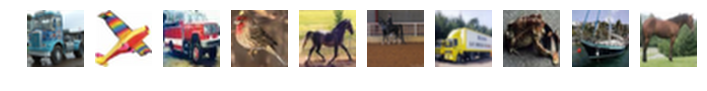

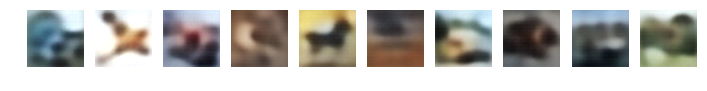

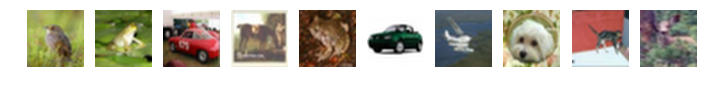

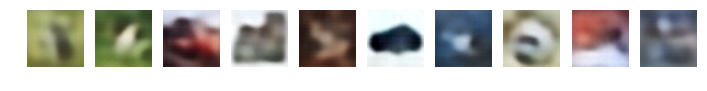

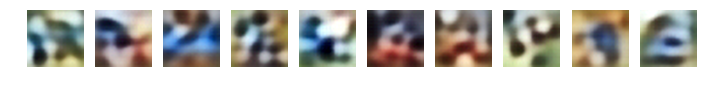

Epoch 6 of 100 took 64.47s;
train reconstruction loss: 28.90; test reconstruction loss: 27.50
train penalty loss: 998.73; test penalty loss: 1021.31
regularization factor = 0.00

Epoch 7 of 100 took 64.48s;
train reconstruction loss: 26.31; test reconstruction loss: 25.79
train penalty loss: 1042.54; test penalty loss: 1072.50
regularization factor = 0.00

Epoch 8 of 100 took 64.48s;
train reconstruction loss: 24.86; test reconstruction loss: 24.89
train penalty loss: 1097.49; test penalty loss: 1129.22
regularization factor = 0.00

Epoch 9 of 100 took 64.58s;
train reconstruction loss: 24.22; test reconstruction loss: 24.53
train penalty loss: 1160.11; test penalty loss: 1183.95
regularization factor = 0.00

Epoch 10 of 100 took 64.45s;
train reconstruction loss: 23.92; test reconstruction loss: 24.00
train penalty loss: 1216.21; test penalty loss: 1237.16
regularization factor = 0.00



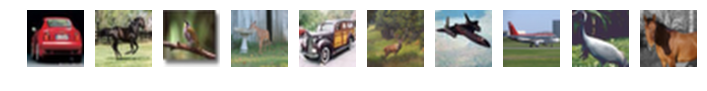

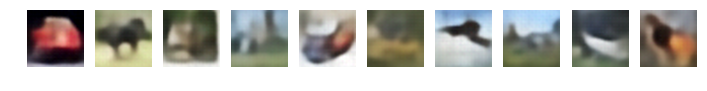

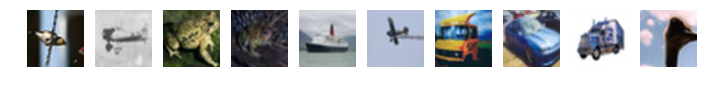

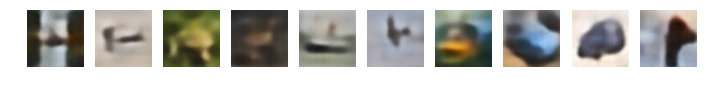

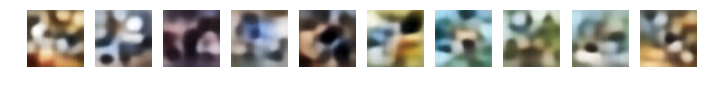

Epoch 11 of 100 took 64.42s;
train reconstruction loss: 23.62; test reconstruction loss: 24.29
train penalty loss: 1265.47; test penalty loss: 1281.06
regularization factor = 0.00

Epoch 12 of 100 took 64.46s;
train reconstruction loss: 34.45; test reconstruction loss: 27.08
train penalty loss: 417.40; test penalty loss: 213.38
regularization factor = 0.01

Epoch 13 of 100 took 64.51s;
train reconstruction loss: 26.47; test reconstruction loss: 26.56
train penalty loss: 176.99; test penalty loss: 166.40
regularization factor = 0.03

Epoch 14 of 100 took 64.48s;
train reconstruction loss: 26.42; test reconstruction loss: 27.05
train penalty loss: 149.70; test penalty loss: 146.02
regularization factor = 0.04

Epoch 15 of 100 took 64.48s;
train reconstruction loss: 26.44; test reconstruction loss: 27.43
train penalty loss: 133.67; test penalty loss: 136.25
regularization factor = 0.05



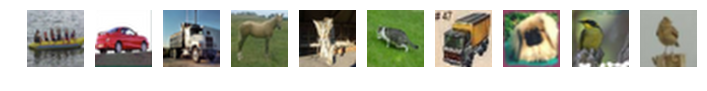

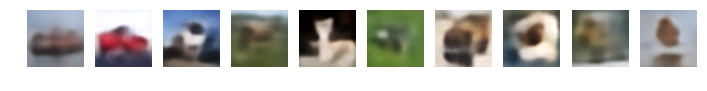

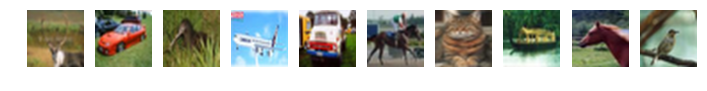

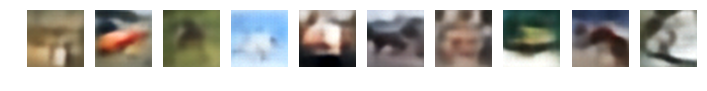

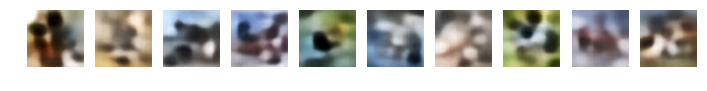

Epoch 16 of 100 took 64.40s;
train reconstruction loss: 26.61; test reconstruction loss: 27.26
train penalty loss: 122.53; test penalty loss: 121.71
regularization factor = 0.06

Epoch 17 of 100 took 64.42s;
train reconstruction loss: 26.70; test reconstruction loss: 27.43
train penalty loss: 113.89; test penalty loss: 116.25
regularization factor = 0.07

Epoch 18 of 100 took 64.44s;
train reconstruction loss: 26.91; test reconstruction loss: 27.86
train penalty loss: 106.91; test penalty loss: 106.44
regularization factor = 0.09

Epoch 19 of 100 took 64.43s;
train reconstruction loss: 27.00; test reconstruction loss: 28.45
train penalty loss: 101.09; test penalty loss: 100.00
regularization factor = 0.10

Epoch 20 of 100 took 64.40s;
train reconstruction loss: 27.27; test reconstruction loss: 28.34
train penalty loss: 96.27; test penalty loss: 97.02
regularization factor = 0.11



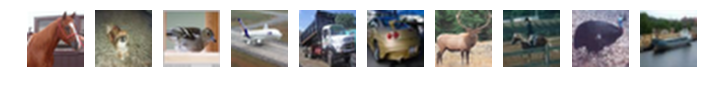

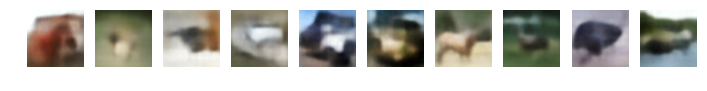

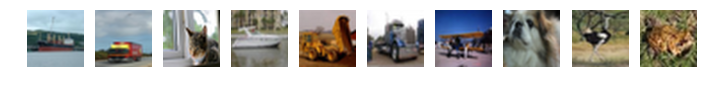

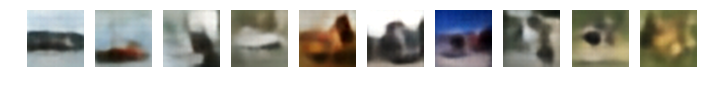

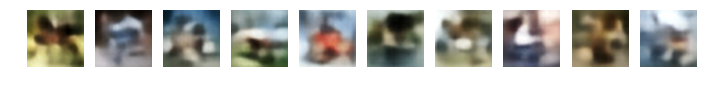

Epoch 21 of 100 took 64.42s;
train reconstruction loss: 27.43; test reconstruction loss: 29.02
train penalty loss: 92.03; test penalty loss: 88.25
regularization factor = 0.12

Epoch 22 of 100 took 64.42s;
train reconstruction loss: 27.57; test reconstruction loss: 29.71
train penalty loss: 88.22; test penalty loss: 88.01
regularization factor = 0.14

Epoch 23 of 100 took 64.44s;
train reconstruction loss: 27.75; test reconstruction loss: 29.60
train penalty loss: 84.73; test penalty loss: 82.61
regularization factor = 0.15

Epoch 24 of 100 took 64.42s;
train reconstruction loss: 27.95; test reconstruction loss: 29.45
train penalty loss: 81.62; test penalty loss: 83.65
regularization factor = 0.16

Epoch 25 of 100 took 64.43s;
train reconstruction loss: 28.16; test reconstruction loss: 30.24
train penalty loss: 78.79; test penalty loss: 75.92
regularization factor = 0.17



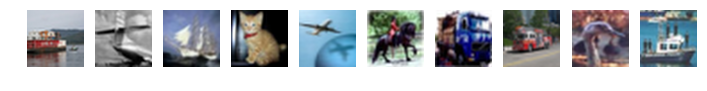

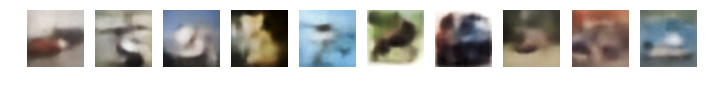

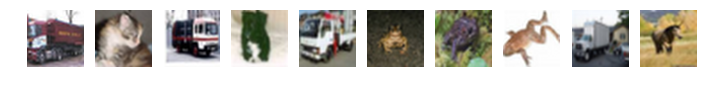

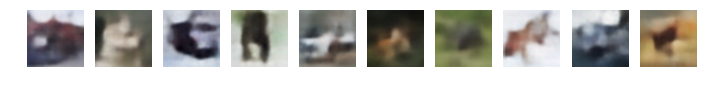

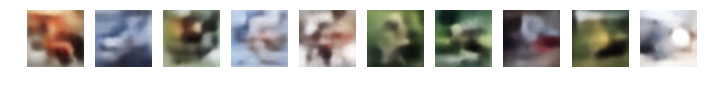

Epoch 26 of 100 took 64.42s;
train reconstruction loss: 28.45; test reconstruction loss: 31.03
train penalty loss: 76.05; test penalty loss: 71.91
regularization factor = 0.19

Epoch 27 of 100 took 64.41s;
train reconstruction loss: 28.70; test reconstruction loss: 30.32
train penalty loss: 73.60; test penalty loss: 74.22
regularization factor = 0.20

Epoch 28 of 100 took 64.43s;
train reconstruction loss: 28.87; test reconstruction loss: 31.17
train penalty loss: 71.34; test penalty loss: 71.77
regularization factor = 0.21

Epoch 29 of 100 took 64.43s;
train reconstruction loss: 29.14; test reconstruction loss: 31.39
train penalty loss: 69.25; test penalty loss: 73.42
regularization factor = 0.23

Epoch 30 of 100 took 64.42s;
train reconstruction loss: 29.41; test reconstruction loss: 32.20
train penalty loss: 67.32; test penalty loss: 67.49
regularization factor = 0.24



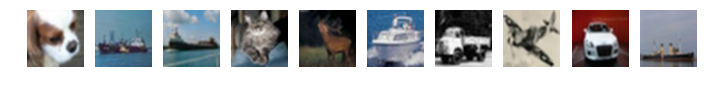

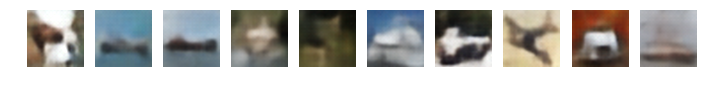

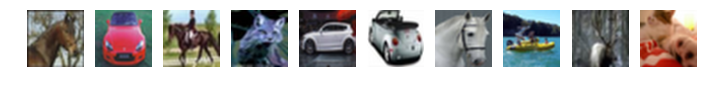

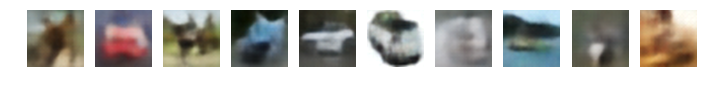

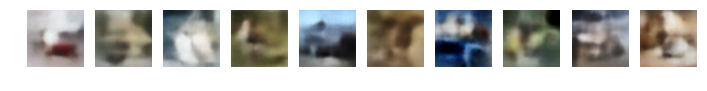

Epoch 31 of 100 took 64.41s;
train reconstruction loss: 28.43; test reconstruction loss: 31.37
train penalty loss: 65.39; test penalty loss: 65.86
regularization factor = 0.25

Epoch 32 of 100 took 64.44s;
train reconstruction loss: 28.67; test reconstruction loss: 31.77
train penalty loss: 63.93; test penalty loss: 64.60
regularization factor = 0.26

Epoch 33 of 100 took 64.42s;
train reconstruction loss: 28.95; test reconstruction loss: 32.05
train penalty loss: 62.51; test penalty loss: 62.99
regularization factor = 0.28

Epoch 34 of 100 took 64.45s;
train reconstruction loss: 29.28; test reconstruction loss: 32.58
train penalty loss: 61.13; test penalty loss: 60.95
regularization factor = 0.29

Epoch 35 of 100 took 64.44s;
train reconstruction loss: 29.54; test reconstruction loss: 33.02
train penalty loss: 59.73; test penalty loss: 58.87
regularization factor = 0.30



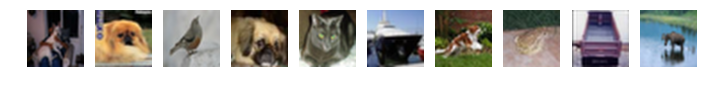

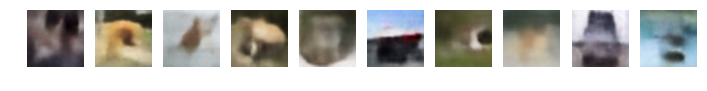

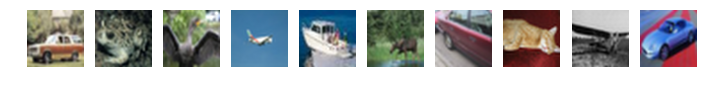

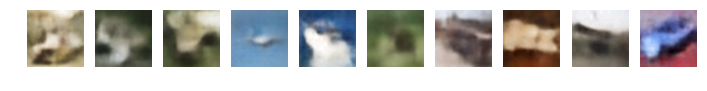

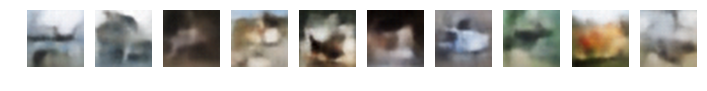

Epoch 36 of 100 took 64.44s;
train reconstruction loss: 29.91; test reconstruction loss: 32.87
train penalty loss: 58.47; test penalty loss: 58.91
regularization factor = 0.31

Epoch 37 of 100 took 64.44s;
train reconstruction loss: 30.18; test reconstruction loss: 33.48
train penalty loss: 57.29; test penalty loss: 57.15
regularization factor = 0.33

Epoch 38 of 100 took 64.39s;
train reconstruction loss: 30.45; test reconstruction loss: 34.02
train penalty loss: 56.06; test penalty loss: 55.38
regularization factor = 0.34

Epoch 39 of 100 took 64.42s;
train reconstruction loss: 30.75; test reconstruction loss: 34.94
train penalty loss: 54.92; test penalty loss: 52.35
regularization factor = 0.35

Epoch 40 of 100 took 64.42s;
train reconstruction loss: 31.05; test reconstruction loss: 34.89
train penalty loss: 53.78; test penalty loss: 52.98
regularization factor = 0.36



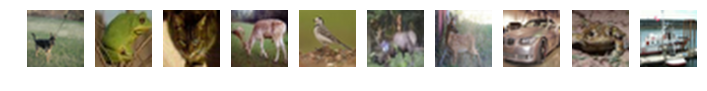

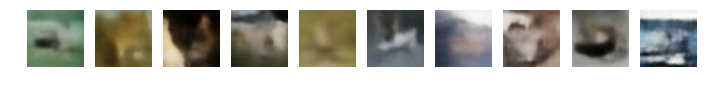

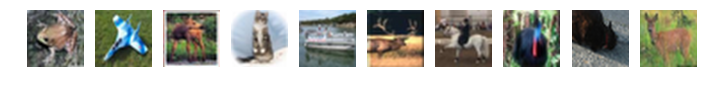

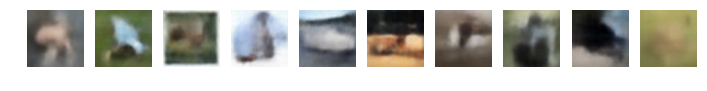

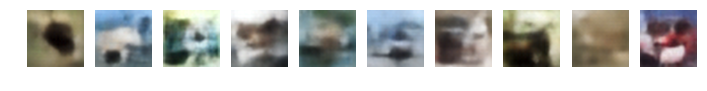

Epoch 41 of 100 took 64.40s;
train reconstruction loss: 31.39; test reconstruction loss: 34.76
train penalty loss: 52.78; test penalty loss: 52.44
regularization factor = 0.38

Epoch 42 of 100 took 64.42s;
train reconstruction loss: 31.71; test reconstruction loss: 35.43
train penalty loss: 51.70; test penalty loss: 50.64
regularization factor = 0.39

Epoch 43 of 100 took 64.43s;
train reconstruction loss: 32.03; test reconstruction loss: 35.16
train penalty loss: 50.76; test penalty loss: 51.33
regularization factor = 0.40

Epoch 44 of 100 took 64.43s;
train reconstruction loss: 32.31; test reconstruction loss: 35.75
train penalty loss: 49.78; test penalty loss: 49.32
regularization factor = 0.41

Epoch 45 of 100 took 64.46s;
train reconstruction loss: 32.63; test reconstruction loss: 36.06
train penalty loss: 48.85; test penalty loss: 48.69
regularization factor = 0.42



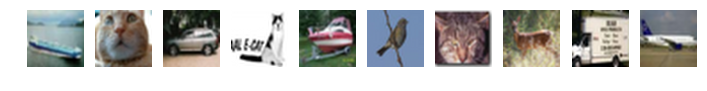

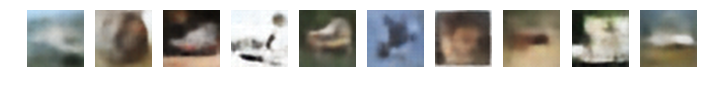

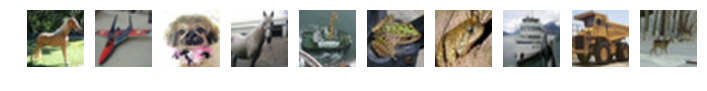

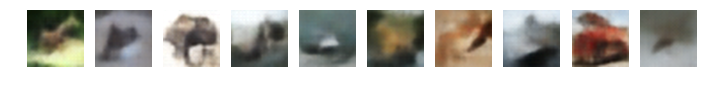

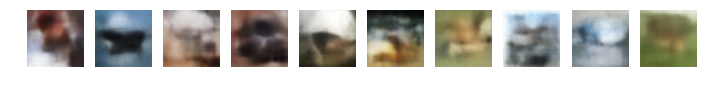

Epoch 46 of 100 took 64.44s;
train reconstruction loss: 32.90; test reconstruction loss: 37.00
train penalty loss: 47.97; test penalty loss: 46.54
regularization factor = 0.44

Epoch 47 of 100 took 64.40s;
train reconstruction loss: 33.28; test reconstruction loss: 35.67
train penalty loss: 47.10; test penalty loss: 49.55
regularization factor = 0.45

Epoch 48 of 100 took 64.41s;
train reconstruction loss: 33.58; test reconstruction loss: 37.05
train penalty loss: 46.33; test penalty loss: 45.97
regularization factor = 0.46

Epoch 49 of 100 took 64.41s;
train reconstruction loss: 33.86; test reconstruction loss: 37.49
train penalty loss: 45.50; test penalty loss: 46.05
regularization factor = 0.47

Epoch 50 of 100 took 64.40s;
train reconstruction loss: 34.16; test reconstruction loss: 37.60
train penalty loss: 44.73; test penalty loss: 44.60
regularization factor = 0.49



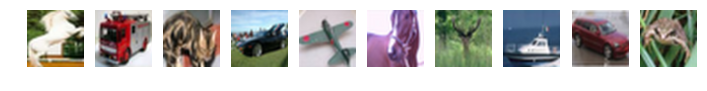

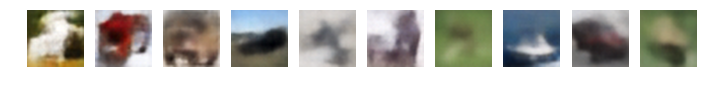

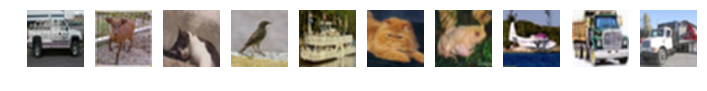

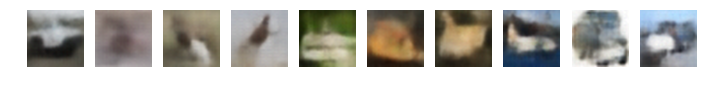

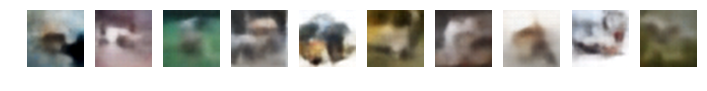

Epoch 51 of 100 took 64.43s;
train reconstruction loss: 33.62; test reconstruction loss: 37.45
train penalty loss: 44.01; test penalty loss: 43.88
regularization factor = 0.50

Epoch 52 of 100 took 64.43s;
train reconstruction loss: 33.78; test reconstruction loss: 37.75
train penalty loss: 43.47; test penalty loss: 43.12
regularization factor = 0.51

Epoch 53 of 100 took 64.44s;
train reconstruction loss: 34.07; test reconstruction loss: 38.23
train penalty loss: 42.81; test penalty loss: 42.45
regularization factor = 0.53

Epoch 54 of 100 took 64.41s;
train reconstruction loss: 34.32; test reconstruction loss: 38.36
train penalty loss: 42.26; test penalty loss: 42.20
regularization factor = 0.54

Epoch 55 of 100 took 64.45s;
train reconstruction loss: 34.63; test reconstruction loss: 38.43
train penalty loss: 41.65; test penalty loss: 42.01
regularization factor = 0.55



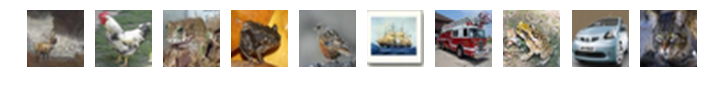

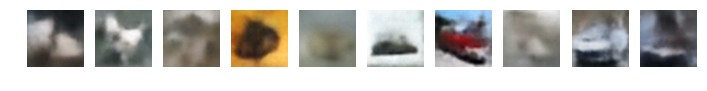

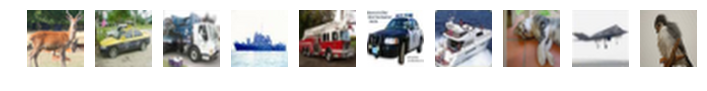

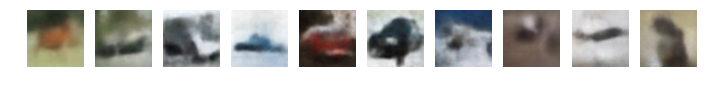

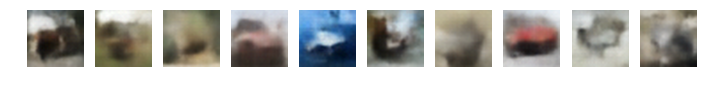

Epoch 56 of 100 took 64.43s;
train reconstruction loss: 34.90; test reconstruction loss: 39.02
train penalty loss: 41.09; test penalty loss: 40.73
regularization factor = 0.56

Epoch 57 of 100 took 64.45s;
train reconstruction loss: 35.19; test reconstruction loss: 39.34
train penalty loss: 40.50; test penalty loss: 39.97
regularization factor = 0.57

Epoch 58 of 100 took 64.42s;
train reconstruction loss: 35.47; test reconstruction loss: 39.25
train penalty loss: 39.95; test penalty loss: 40.28
regularization factor = 0.59

Epoch 59 of 100 took 64.42s;
train reconstruction loss: 35.79; test reconstruction loss: 39.47
train penalty loss: 39.44; test penalty loss: 39.84
regularization factor = 0.60

Epoch 60 of 100 took 64.42s;
train reconstruction loss: 36.01; test reconstruction loss: 39.97
train penalty loss: 38.91; test penalty loss: 38.76
regularization factor = 0.61



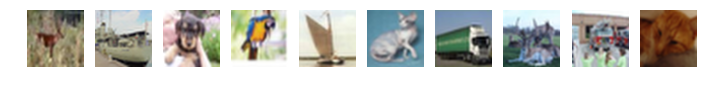

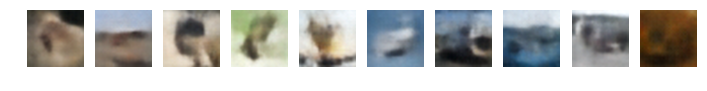

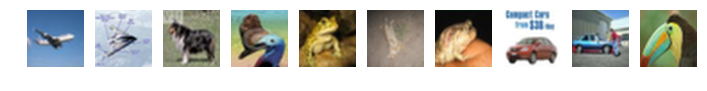

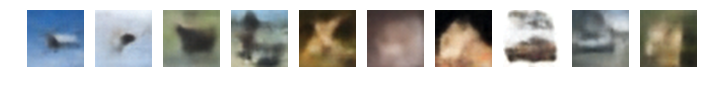

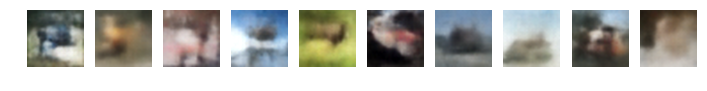

Epoch 61 of 100 took 64.44s;
train reconstruction loss: 36.34; test reconstruction loss: 40.20
train penalty loss: 38.36; test penalty loss: 38.21
regularization factor = 0.62

Epoch 62 of 100 took 64.43s;
train reconstruction loss: 36.62; test reconstruction loss: 40.50
train penalty loss: 37.89; test penalty loss: 37.87
regularization factor = 0.64

Epoch 63 of 100 took 64.49s;
train reconstruction loss: 36.93; test reconstruction loss: 41.03
train penalty loss: 37.35; test penalty loss: 36.93
regularization factor = 0.65

Epoch 64 of 100 took 64.47s;
train reconstruction loss: 37.25; test reconstruction loss: 40.96
train penalty loss: 36.84; test penalty loss: 36.92
regularization factor = 0.66

Epoch 65 of 100 took 64.46s;
train reconstruction loss: 37.52; test reconstruction loss: 41.53
train penalty loss: 36.41; test penalty loss: 36.07
regularization factor = 0.68



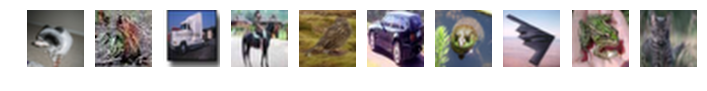

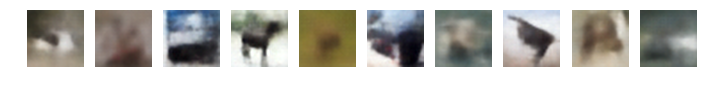

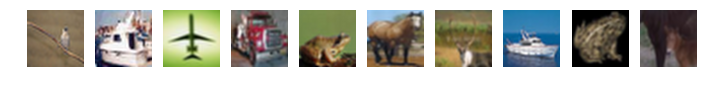

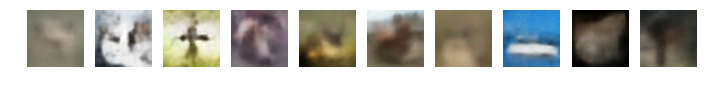

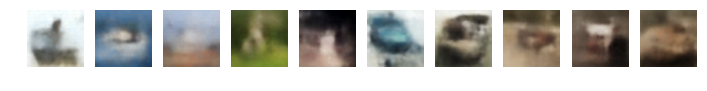

Epoch 66 of 100 took 64.40s;
train reconstruction loss: 37.81; test reconstruction loss: 41.50
train penalty loss: 35.94; test penalty loss: 35.89
regularization factor = 0.69

Epoch 67 of 100 took 64.42s;
train reconstruction loss: 38.15; test reconstruction loss: 41.81
train penalty loss: 35.49; test penalty loss: 35.47
regularization factor = 0.70

Epoch 68 of 100 took 64.40s;
train reconstruction loss: 38.40; test reconstruction loss: 42.06
train penalty loss: 35.09; test penalty loss: 34.94
regularization factor = 0.71

Epoch 69 of 100 took 64.43s;
train reconstruction loss: 38.67; test reconstruction loss: 42.41
train penalty loss: 34.63; test penalty loss: 34.33
regularization factor = 0.72

Epoch 70 of 100 took 64.44s;
train reconstruction loss: 38.99; test reconstruction loss: 42.40
train penalty loss: 34.18; test penalty loss: 34.40
regularization factor = 0.74



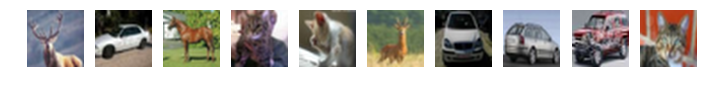

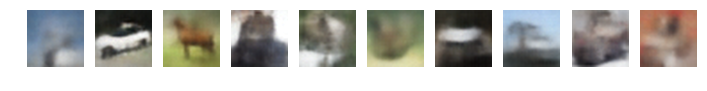

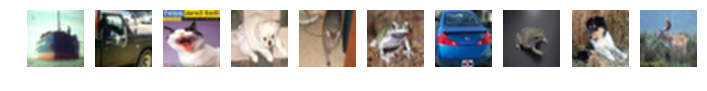

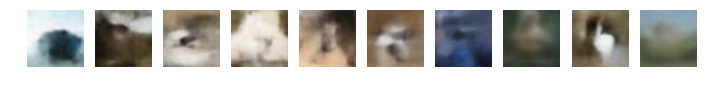

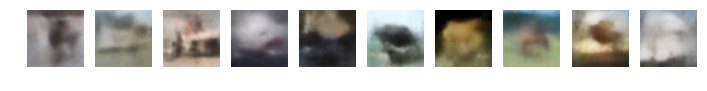

Epoch 71 of 100 took 64.41s;
train reconstruction loss: 39.26; test reconstruction loss: 42.86
train penalty loss: 33.77; test penalty loss: 33.79
regularization factor = 0.75

Epoch 72 of 100 took 64.44s;
train reconstruction loss: 39.53; test reconstruction loss: 43.47
train penalty loss: 33.37; test penalty loss: 32.85
regularization factor = 0.76

Epoch 73 of 100 took 64.43s;
train reconstruction loss: 39.83; test reconstruction loss: 43.54
train penalty loss: 32.92; test penalty loss: 32.64
regularization factor = 0.78

Epoch 74 of 100 took 64.42s;
train reconstruction loss: 40.10; test reconstruction loss: 43.81
train penalty loss: 32.54; test penalty loss: 32.31
regularization factor = 0.79

Epoch 75 of 100 took 64.43s;
train reconstruction loss: 40.40; test reconstruction loss: 43.65
train penalty loss: 32.16; test penalty loss: 32.49
regularization factor = 0.80



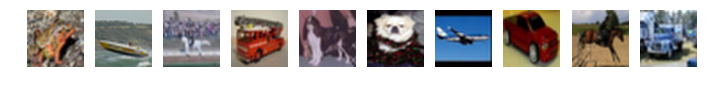

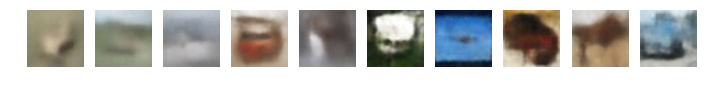

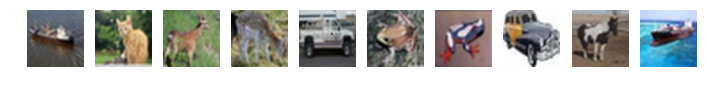

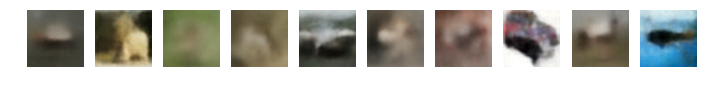

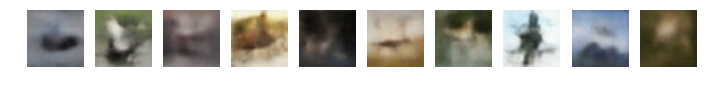

Epoch 76 of 100 took 64.40s;
train reconstruction loss: 40.70; test reconstruction loss: 44.26
train penalty loss: 31.80; test penalty loss: 31.56
regularization factor = 0.81

Epoch 77 of 100 took 64.45s;
train reconstruction loss: 40.96; test reconstruction loss: 45.07
train penalty loss: 31.39; test penalty loss: 30.52
regularization factor = 0.82

Epoch 78 of 100 took 64.44s;
train reconstruction loss: 41.24; test reconstruction loss: 45.11
train penalty loss: 31.01; test penalty loss: 30.43
regularization factor = 0.84

Epoch 79 of 100 took 64.43s;
train reconstruction loss: 41.48; test reconstruction loss: 44.85
train penalty loss: 30.69; test penalty loss: 30.70
regularization factor = 0.85

Epoch 80 of 100 took 64.42s;
train reconstruction loss: 41.76; test reconstruction loss: 45.45
train penalty loss: 30.32; test penalty loss: 29.99
regularization factor = 0.86



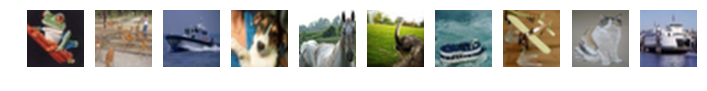

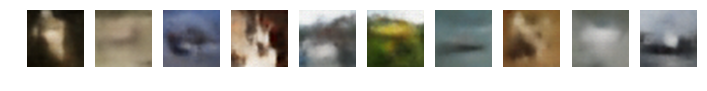

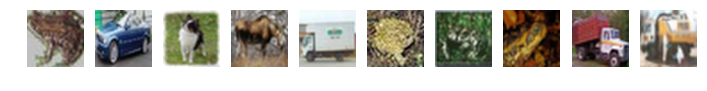

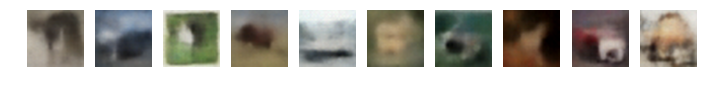

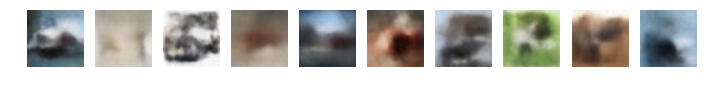

Epoch 81 of 100 took 64.44s;
train reconstruction loss: 42.03; test reconstruction loss: 45.28
train penalty loss: 30.01; test penalty loss: 30.02
regularization factor = 0.88

Epoch 82 of 100 took 64.41s;
train reconstruction loss: 42.32; test reconstruction loss: 45.71
train penalty loss: 29.65; test penalty loss: 29.47
regularization factor = 0.89

Epoch 83 of 100 took 64.49s;
train reconstruction loss: 42.62; test reconstruction loss: 46.15
train penalty loss: 29.33; test penalty loss: 28.91
regularization factor = 0.90

Epoch 84 of 100 took 64.46s;
train reconstruction loss: 42.89; test reconstruction loss: 46.42
train penalty loss: 28.97; test penalty loss: 28.60
regularization factor = 0.91



In [ ]:
latent_dim = 64

num_epochs = 100
save_every = 10

name_prefix = 'vae_results/'

#try:
if True:
#    wae = WAE_WGAN(input_shape, latent_dim).to(device)
#    wae.load_state_dict(torch.load(name_prefix + 'wae_gan.pt'))
#    print("Found pretrained WAE-GAN")
#except:
#    print("Didn't found pretrained WAE-GAN; training...")
    
    vae = VAE(input_shape, latent_dim).to(device)
    optimizer = optim.Adam(
        vae.parameters(), lr=3e-4, betas=(0.5, 0.999)
    )

    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    )

    for epoch in range(num_epochs):
        start_time = time()
        
        scheduler.step()
        
        regularization_factor = np.clip((epoch-10) / (num_epochs-10*2), 0, 1)
        
        cum_loss_reconstruction = 0
        cum_loss_penalty = 0
        batch_count = 0
        
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)

            loss_reconstruction, loss_penalty = vae.batch_loss(X_batch)
            cum_loss_reconstruction += loss_reconstruction.item()
            cum_loss_penalty += loss_penalty.item()
                
            optimizer.zero_grad()
            (loss_reconstruction + loss_penalty * regularization_factor).backward()
            optimizer.step()
            batch_count += 1
    
        mean_train_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_train_loss_penalty = cum_loss_penalty / batch_count

        cum_loss_reconstruction = 0
        cum_loss_penalty = 0
        batch_count = 0
        
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(device)

                loss_reconstruction, loss_penalty = vae.batch_loss(X_batch)
                cum_loss_reconstruction += loss_reconstruction.item()
                cum_loss_penalty += loss_penalty.item()
        
                batch_count += 1
            
        mean_test_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_test_loss_penalty = cum_loss_penalty / batch_count

        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train reconstruction loss: {:.2f}; test reconstruction loss: {:.2f}'.format(
            mean_train_loss_reconstruction, mean_test_loss_reconstruction
        ))
        print('train penalty loss: {:.2f}; test penalty loss: {:.2f}'.format(
            mean_train_loss_penalty, mean_test_loss_penalty
        ))
        print('regularization factor = {:.2f}'.format(regularization_factor))
        print()
        
        if (epoch+1) % 5 == 0:
            X_batch = next(iter(train_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                vae.generative_network(
                    vae.sample_latent(
                        *vae.proposal_distr(X_batch)
                    )
                )
            )
            plt.show()
            X_batch = next(iter(test_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                vae.generative_network(
                    vae.sample_latent(
                        *vae.proposal_distr(X_batch)
                    )
                )
            )
            plt.show()
            show_images(vae.generate_samples(10))
            plt.show()
    
        if (epoch+1) % save_every == 0:
            torch.save(vae.state_dict(), name_prefix + 'vae.pt')
        


In [ ]:
for label in range(10):
    show_images(vae.generate_samples(10))
    plt.show()

**Tangent prop**

In [ ]:
def constrain_loss_function(model, generative_model, batch_gen=None, reparam_invariant=True, use_all_classes=False):
    latent_dim = generative_model.latent_dim
    
    if reparam_invariant:
        if batch_gen is None:
            z_gen = torch.normal(std=torch.ones(batch_size, latent_dim, device=device)) # [batch_size x latent_dim]
            X_gen = generative_model.generative_distr(z_gen).detach().requires_grad_() # [batch_size x C x H x W]
        else:
            X_gen, _ = next(batch_gen)
            X_gen = X_gen.to(device).requires_grad_()
        z_inferred = generative_model.sample_latent(*generative_model.proposal_distr(X_gen)) # [batch_size x latent_dim]
    else:
        if batch_gen is None:
            z_inferred = torch.normal(
                std=torch.ones(batch_size, latent_dim, device=device)
            ).requires_grad_() # [batch_size x latent_dim]
        else:
            X, _ = next(batch_gen)
            X = X.to(device)
            z_inferred = generative_model.sample_latent(
                *generative_model.proposal_distr(X)
            ).detach().requires_grad_() # [batch_size x latent_dim]
    X_inferred = generative_model.generative_distr(z_inferred) # [batch_size x C x H x W]
    model_output = model(X_inferred) # [batch_size x num_classes]
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen if reparam_invariant else z_inferred], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen if reparam_invariant else z_inferred], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [ ]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            nn.Dropout(p=0.2),
            nn.Conv2d(input_shape[0], 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(6)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return F.log_softmax(self.output_layer(X), dim=1)

In [ ]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

In [ ]:
num_epochs = 200
save_every = 10

modes = ['stochastic_manifold_reg_on_train_data__eta=' + str(eta) for eta in [0, 1e-5, 1e-4, 1e-3, 1e-2]]

loss_function = nn.NLLLoss()

for mode in modes:
    mode_name = mode + '__labelled=4000__epochs=' + str(num_epochs)
    eta = float(mode.split('=')[1])

    print('Mode:', mode)
    print(mode_name)
    print('eta =', eta)
    print()
    
    train_losses[mode] = []
    train_accs[mode] = []
    
    test_losses[mode] = []
    test_accs[mode] = []

    torch.manual_seed(123)
    np.random.seed(123)
    model = ModelConvolutional(input_shape, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
    #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
    for epoch in range(num_epochs):
        start_time = time()
    
        #scheduler.step()
    
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_loss_full = 0
        cum_acc = 0
        batch_count = 0

        model.train()
        train_iter_unlabelled = iter(train_loader_unlabelled)
        for X, y in train_loader_labelled:
            X, y = X.to(device), y.to(device)
            prediction = model(X)
            loss_data = loss_function(prediction, y)
            cum_loss_data += loss_data.item()
        
            loss_constrain = constrain_loss_function(
                model, vae, reparam_invariant=True, use_all_classes=False, batch_gen=train_iter_unlabelled
            )
            cum_loss_constrain += loss_constrain.item()
        
            loss_full = loss_data + eta * loss_constrain
            cum_loss_full += loss_full.item()
            
            acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
            cum_acc += acc.item()
        
            optimizer.zero_grad()
            loss_full.backward()
            optimizer.step()
            batch_count += 1
            
        mean_train_loss_data = cum_loss_data / batch_count
        mean_train_loss_constrain = cum_loss_constrain / batch_count
        mean_train_loss_full = cum_loss_full / batch_count
        mean_train_acc = cum_acc / batch_count

        train_losses[mode].append(mean_train_loss_data)
        train_accs[mode].append(mean_train_acc)
        
        cum_loss_data = 0
        cum_loss_constrain = 0
        cum_acc = 0
        batch_count = 0

        model.eval()
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                prediction = model(X)
                loss_data = loss_function(prediction, y)
                cum_loss_data += loss_data.item()
        
                acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                cum_acc += acc.item()
        
                batch_count += 1
            
        mean_test_loss_data = cum_loss_data / batch_count
        mean_test_loss_constrain = cum_loss_constrain / batch_count
        mean_test_acc = cum_acc / batch_count

        test_losses[mode].append(mean_test_loss_data)
        test_accs[mode].append(mean_test_acc)
        
        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
            )
        )
        print('train acc: {:.2f}'.format(mean_train_acc*100))
        print('test loss:')
        print(
            'data term: {:.2f}, constrain term: {:.2f}'.format(
                mean_test_loss_data, mean_test_loss_constrain
            )
        )
        print('test acc: {:.2f}'.format(mean_test_acc*100))
        print()
        
        if (epoch+1) % save_every == 0:
            with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                pickle.dump(np.array(train_losses[mode]), f)
            with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                pickle.dump(np.array(test_losses[mode]), f)
            with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                pickle.dump(np.array(train_accs[mode]), f)
            with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                pickle.dump(np.array(test_accs[mode]), f)

            torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')



In [57]:
from pandas import ewma, DataFrame

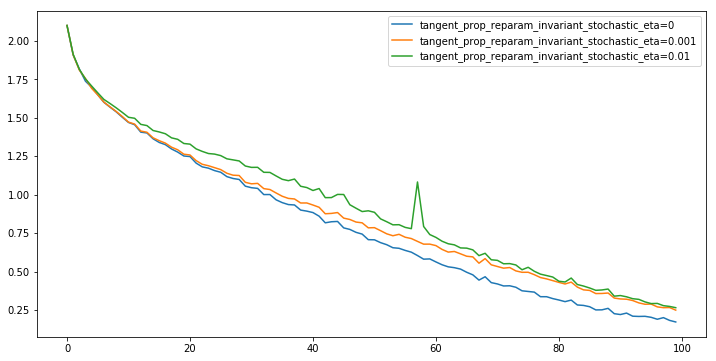

In [65]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(train_losses[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


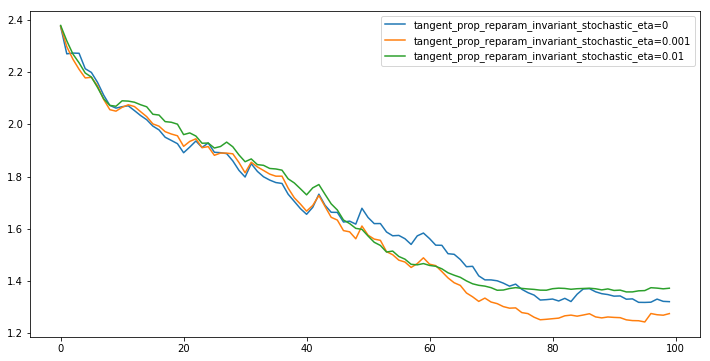

In [66]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(ewma(DataFrame(test_losses[mode]), alpha=0.1))
plt.legend(modes)

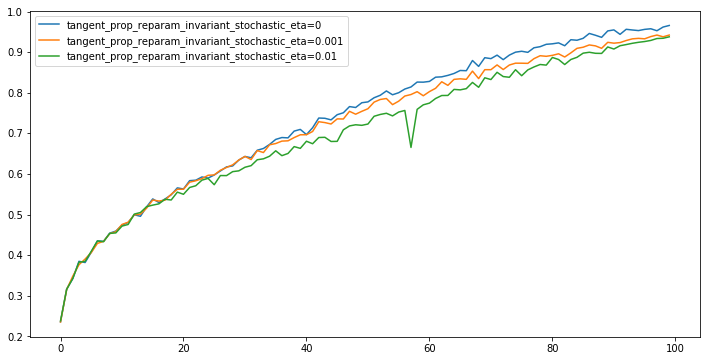

In [67]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(train_accs[mode])
plt.legend(modes)

/home/golikov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(alpha=0.1,min_periods=0,adjust=True,ignore_na=False).mean()
  after removing the cwd from sys.path.


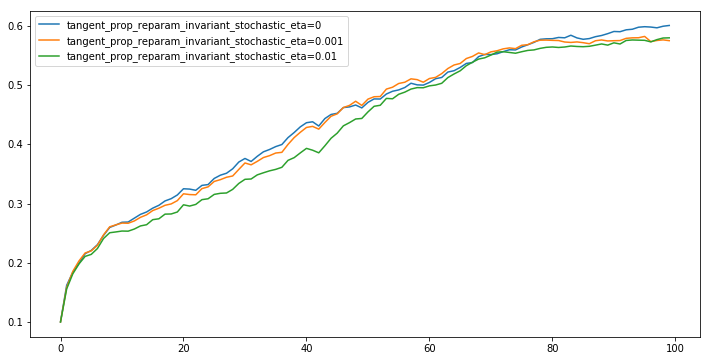

In [68]:
plt.figure(figsize=(12, 6))

for mode in modes[:3]:
    plt.plot(ewma(DataFrame(test_accs[mode]), alpha=0.1))
plt.legend(modes)